# Inverse Problem: General Workflow and Examples

In this example script, we'll reproduce many of the plots from the fitting release paper ([Conroy et al. 2020](http://phoebe-project.org/publications/2020Conroy+)).

# Setup


Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

First we'll import, set our plotting options, and set a fixed random seed so that our noise model is reproducible between runs.

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', family='serif')

In [3]:
import phoebe
import numpy as np

logger = phoebe.logger('error')

# we'll set the random seed so that the noise model is reproducible
np.random.seed(123456789)

# Create fake "observations"

Now we'll create a fake set of observations by setting some parameter values, running a forward model, and adding some simple random noise on both the fluxes and RVs.

In [4]:
b = phoebe.default_binary()
b.set_value('ecc', 0.2)
b.set_value('per0', 25)
b.set_value('teff@primary', 7000)
b.set_value('teff@secondary', 6000)
b.set_value('sma@binary', 7)
b.set_value('incl@binary', 80)
b.set_value('q', 0.3)
b.set_value('t0_supconj', 0.1)
#b.set_value('requiv@primary', 0.95*b.get_value('requiv_max@primary@component'))  # rv_geometry fails to converge
b.set_value('requiv@primary', 2.0)

lctimes = phoebe.linspace(0, 10, 1005)
rvtimes = phoebe.linspace(0, 10, 105)
b.add_dataset('lc', compute_times=lctimes)
b.add_dataset('rv', compute_times=rvtimes)
b.set_value_all('ld_mode', 'lookup')
b.run_compute(irrad_method='none')

fluxes = b.get_value('fluxes@model') + np.random.normal(size=lctimes.shape) * 0.01
fsigmas = np.ones_like(lctimes) * 0.02

rvsA = b.get_value('rvs@primary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsB = b.get_value('rvs@secondary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsigmas = np.ones_like(rvtimes) * 20

In [5]:
# TESTING to compare to ebai - REMOVE 
b.add_constraint('teffratio')
b.add_constraint('requivsumfrac')
print(b.filter(qualifier=['teffratio', 'requivsumfrac'], context='component'))

ParameterSet: 2 parameters
C      teffratio@binary@component: 0.8571428571428572
C  requivsumfrac@binary@component: 0.42857142857142855


# Create a new bundle/system

Now we'll start over "blind" with a fresh bundle and import our "fake" observations in datasets.

In [6]:
b = phoebe.default_binary()
b.add_dataset('lc', times=lctimes, fluxes=fluxes, sigmas=fsigmas, dataset='lc01')
b.add_dataset('rv', times=rvtimes, rvs={'primary': rvsA, 'secondary': rvsB}, sigmas=rvsigmas, dataset='rv01')
b.set_value_all('ld_mode', 'lookup')

For the sake of this example, we'll assume that we know the orbital period *exactly*, and so can see that our observations phase nicely.  

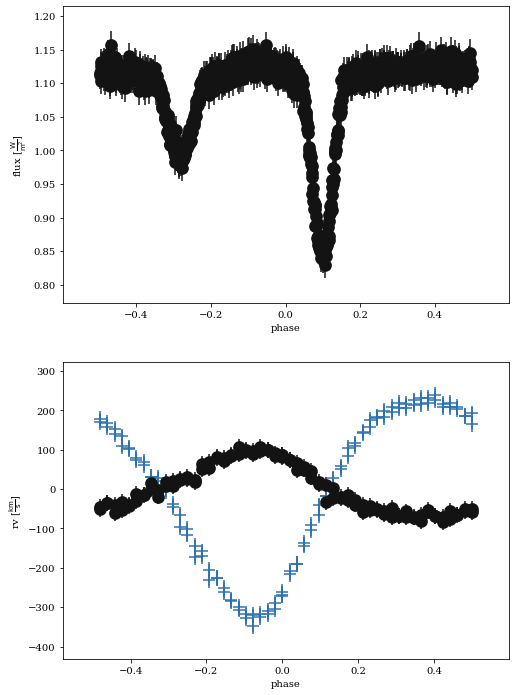

In [7]:
afig, mplfig = b.plot(x='phases', show=True)

# Run rv_geometry estimator

First we'll run the [rv_geometry estimator](../api/phoebe.parameters.solver.estimator.rv_geometry.md) via [b.add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md) and [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md).

In [8]:
b.add_solver('estimator.rv_geometry',
             rv='rv01')

<ParameterSet: 4 parameters | qualifiers: orbit, rv_datasets, comments, expose_model>

In [9]:
b.run_solver(kind='rv_geometry', solution='rv_geom_sol')

<ParameterSet: 18 parameters | components: secondary, primary>

By calling [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md) with `trial_run=True`, we can see the proposed values by the estimator.

In [10]:
print(b.adopt_solution('rv_geom_sol', trial_run=True))

ParameterSet: 5 parameters
   t0_supconj@binary@orbit@com...: 0.13849243114049464 d
         q@binary@orbit@component: 0.324442993022286
     asini@binary@orbit@component: 7.69096152425373 solRad
       ecc@binary@orbit@component: 0.17076023483998734
      per0@binary@orbit@component: 49.90093457763492 deg


And by plotting the solution, we can see the underlying Keplerian orbit that was fitted to the RVs to determine these values.  

This reproduces Figure ??? ...

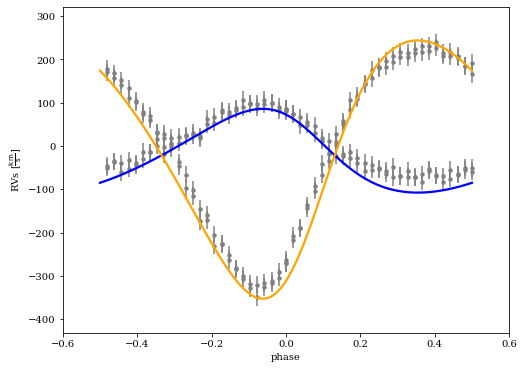

In [11]:
afig, mplfig = b.plot(solution='rv_geom_sol',
                      show=True, save='figure_rv_geometry.eps')

# Run lc_geometry estimator

Next we'll run the [lc_geometry estimator](../api/phoebe.parameters.solver.estimator.lc_geometry.md).

In [12]:
b.add_solver('estimator.lc_geometry',
             lc='lc01')

<ParameterSet: 6 parameters | qualifiers: orbit, t0_near_times, lc_datasets, comments, expose_model, lc_combine>

In [13]:
b.run_solver(kind='lc_geometry', solution='lc_geom_sol')

/home/kyle/.local/lib/python3.7/site-packages/phoebe/solverbackends/lc_geometry.py:73: RuntimeWarning: invalid value encountered in greater
  ph_cross = phases[fluxes - np.nanmedian(fluxes) > 0]
/home/kyle/.local/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/kyle/.local/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


<ParameterSet: 22 parameters | qualifiers: adopt_parameters, primary_depth, input_sigmas, fitted_twigs, primary_width, fitted_units, input_phases, secondary_phase, comments, fitted_uniqueids, analytic_best_model, input_fluxes, adopt_distributions, primary_phase, secondary_depth, orbit, analytic_phases, adopt_values, eclipse_edges, analytic_fluxes, fitted_values, secondary_width>

Again, calling [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md) with `trial_run=True` shows the proposed values.

In [14]:
print(b.adopt_solution('lc_geom_sol', trial_run=True))

ParameterSet: 3 parameters
   t0_supconj@binary@orbit@com...: 0.09910523939690839 d
       ecc@binary@orbit@component: 0.19835532607616524
      per0@binary@orbit@component: 349.8328009524799 deg


By plotting the solution, we get Figure ???, which shows the best two gaussian model as well as the detected positions of mid-eclipse, ingress, and egress which were used to compute the proposed values.

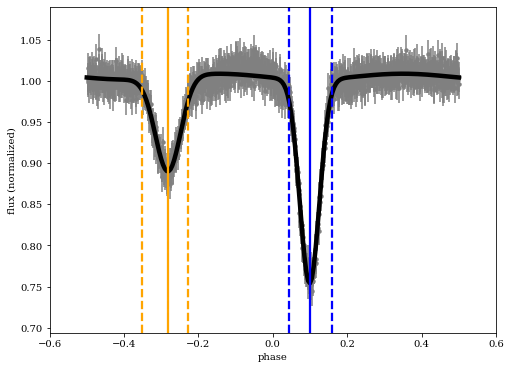

In [15]:
afig, mplfig = b.plot(solution='lc_geom_sol',
                      show=True, save='figure_lc_geometry.eps')

Figure ??? in the paper which shows the seven underlying two gaussian models cannot directly be generated from the plotting functionality within PHOEBE, but the arrays are stored in the solution and can be plotted manually, as shown below.

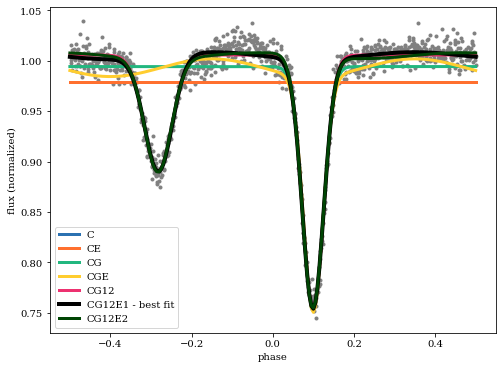

In [16]:
from phoebe.dependencies.autofig.cyclers import _mplcolors as cmap

input_phases = b.get_value('input_phases', solution='lc_geom_sol')
input_fluxes = b.get_value('input_fluxes', solution='lc_geom_sol')
input_sigmas = b.get_value('input_sigmas', solution='lc_geom_sol')

analytic_phases = b.get_value('analytic_phases', solution='lc_geom_sol')
analytic_fluxes_dict = b.get_value('analytic_fluxes', solution='lc_geom_sol')
analytic_best_model = b.get_value('analytic_best_model', solution='lc_geom_sol')

plt.figure(figsize=(8,6))
plt.plot(input_phases, input_fluxes, ls='None', marker='.', c='gray',)
for i, (model, analytic_fluxes) in enumerate(analytic_fluxes_dict.items()):
    plt.plot(analytic_phases, analytic_fluxes, 
             label="{} - best fit".format(model) if model==analytic_best_model else model, 
             lw=4 if model==analytic_best_model else 3, 
             c='k' if model==analytic_best_model else cmap[i+1])
    
plt.xlabel('phase')
plt.ylabel('flux (normalized)')
plt.legend()
plt.savefig('figure_lc_geometry_models.eps')

Figure ??? exhibits eclipse masking by adopting `mask_phases` from the `lc_geometry` solution.  Note that by default, `mask_phases` is not included in `adopt_parameters`, which is why it was not included when calling [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md) with `trial_mode=True` (all available proposed parameters could be shown by passing `adopt_parameters='*'`.  For the sake of this figure, we'll only adopt the `mask_phases`, plot the dataset with that mask applied, but then disable the mask for the rest of this example script.

In [17]:
b.adopt_solution('lc_geom_sol', adopt_parameters='mask_phases')

<ParameterSet: 1 parameters>

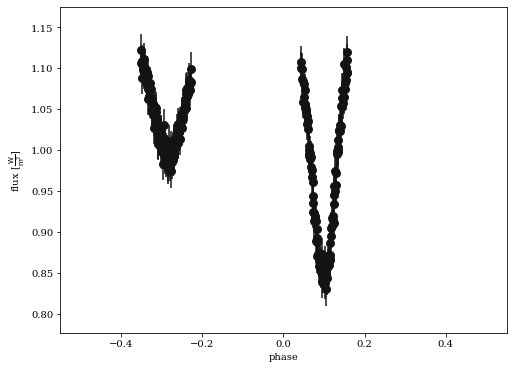

In [18]:
_ = b.plot(context='dataset', dataset='lc01', x='phases', xlim=(-0.55,0.55),
           save='figure_lc_geometry_mask.eps', show=True)

In [19]:
b.set_value('mask_enabled@lc01', False)

# Run ebai estimator

And finally, we'll do the same for the [ebai estimator](../api/phoebe.parameters.solver.estimator.ebai.md).

In [20]:
b.add_solver('estimator.ebai',
             lc='lc01')

<ParameterSet: 4 parameters | qualifiers: orbit, comments, lc_combine, lc_datasets>

In [21]:
b.run_solver(kind='ebai', solution='ebai_sol')

/home/kyle/.local/lib/python3.7/site-packages/phoebe/solverbackends/lc_geometry.py:73: RuntimeWarning: invalid value encountered in greater
  ph_cross = phases[fluxes - np.nanmedian(fluxes) > 0]


<ParameterSet: 13 parameters | qualifiers: orbit, ebai_phases, adopt_parameters, ebai_fluxes, input_fluxes, fitted_twigs, comments, adopt_values, adopt_distributions, fitted_values, fitted_units, input_phases, fitted_uniqueids>

In [22]:
print(b.adopt_solution('ebai_sol', trial_run=True))

ParameterSet: 6 parameters
   t0_supconj@binary@orbit@com...: 0.10557768924302735 d
       teffratio@binary@component: 0.7283639247068527
   requivsumfrac@binary@component: 0.40450603356374737
     esinw@binary@orbit@component: 0.024542128798224372
     ecosw@binary@orbit@component: 0.22017405823044767
      incl@binary@orbit@component: 74.80751967511964 deg


By plotting the `ebai` solution, we reproduce Figure ???, which shows the normalized light curve observations and the resulting sample two gaussian model that is sent to the neural network.

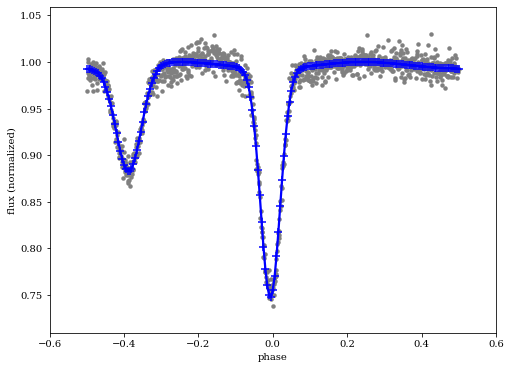

In [23]:
afig, mplfig = b.plot(solution='ebai_sol',
                      show=True, save='figure_ebai.eps')

# Adopt from estimators

Now we'll adopt the proposed values from the two geometry estimators.

In [23]:
b.flip_constraint('asini@binary', solve_for='sma@binary')
b.adopt_solution('rv_geom_sol')

<ParameterSet: 22 parameters | contexts: dataset, component>

In [24]:
b.adopt_solution('lc_geom_sol')

<ParameterSet: 12 parameters | contexts: dataset, component>

We'll keep the eccentricity and per0 estimates from the lc geometry, but use the ebai results to adopt the values for the temperature ratio, sum of fractional radii, and inclination.  Note that since we flipped the asini constraint earlier, that value from the rv geometry will remain fixed and the semi-major axis will be adjusted based on asini from rv geometry and incl from ebai.

In [25]:
b.flip_constraint('teffratio', solve_for='teff@primary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.adopt_solution('ebai_sol', adopt_parameters=['teffratio', 'requivsumfrac', 'incl'])

<ParameterSet: 16 parameters | kinds: orbit, star>

In [26]:
print(b.filter(qualifier=['ecc', 'per0', 'teff', 'sma', 'incl', 'q', 'requiv'], context='component'))

ParameterSet: 13 parameters
C        requiv@primary@component: 1.2879849437760955 solRad
C          teff@primary@component: 8715.673786889189 K
C          incl@primary@component: 83.56963307800714 deg
       requiv@secondary@component: 1.0 solRad
         teff@secondary@component: 6000.0 K
C        incl@secondary@component: 83.56963307800714 deg
            per0@binary@component: 349.8327988085335 deg
             ecc@binary@component: 0.19835528468915015
            incl@binary@component: 83.56963307800714 deg
               q@binary@component: 0.324442993022286
C            sma@binary@component: 7.7396540037284085 solRad
C           sma@primary@component: 1.8959491070253343 solRad
C         sma@secondary@component: 5.843704896703074 solRad


Now we can run a forward model with these adopted parameters to see how well the results from the estimators agree with the observations.

In [27]:
b.run_compute(irrad_method='none', model='after_estimators', overwrite=True)

<ParameterSet: 7 parameters | kinds: lc, rv>

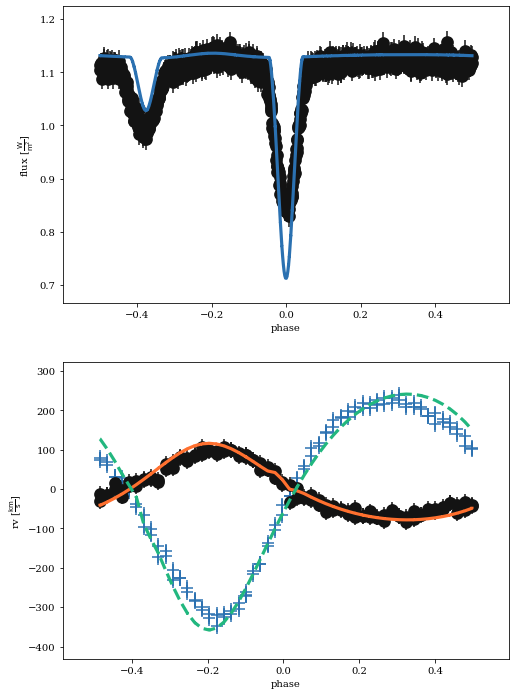

In [28]:
_ = b.plot(x='phases', show=True)

In [29]:
# TESTING to compare ebai to original values at top
print(b.filter(qualifier=['teffratio', 'requivsumfrac'], context='component'))

ParameterSet: 2 parameters
       teffratio@binary@component: 0.6884149346004297
   requivsumfrac@binary@component: 0.33282752514663755


# Optimize with nelder_mead using ellc

To avoid a long burnin during sampling, we'll use the [nelder_mead optimizer](../api/phoebe.parameters.solver.optimizer.nelder_mead.md) to try to achieve better agreement with the observations.

We'll use [ellc](../api/phoebe.parameters.compute.ellc.md) as our forward-model just for the sake of computational efficiency.  

In [30]:
b.add_compute('ellc', compute='fastcompute')

<ParameterSet: 33 parameters | datasets: lc01, rv01, _default>

For the sake of optimizing, we'll use `pblum_mode='dataset-scaled'` which will automatically re-scale the light curve to the observations at each iteration - we'll disable this later for sampling to make sure we account for any degeneracies between the luminosity and other parameters.

In [31]:
b.set_value_all('pblum_mode', 'dataset-scaled')

In [32]:
b.add_solver('optimizer.nelder_mead',
             fit_parameters=['teffratio', 'requivsumfrac', 'incl', 'q', 'ecc', 'per0'],
             compute='fastcompute')

<ParameterSet: 12 parameters | qualifiers: maxfev, comments, xatol, priors, maxiter, fatol, fit_parameters, compute, priors_combine, initial_values, expose_lnlikelihoods, adaptive>

In [33]:
print(b.get_solver(kind='nelder_mead'))

ParameterSet: 11 parameters
    comments@nelder_mead01@solver: 
     compute@nelder_mead01@solver: fastcompute
   expose_lnlikelihoods@nelder...: False
   fit_parameters@nelder_mead0...: ['teffratio', 'requivsumfrac', 'incl', 'q', 'ecc', 'per0']
   initial_values@nelder_mead0...: {}
      priors@nelder_mead01@solver: []
     maxiter@nelder_mead01@solver: 1000000
      maxfev@nelder_mead01@solver: 1000000
    adaptive@nelder_mead01@solver: False
       xatol@nelder_mead01@solver: 0.0001
       fatol@nelder_mead01@solver: 0.0001


In [34]:
b.run_solver(kind='nelder_mead', maxfev=1000, solution='nm_sol')

<ParameterSet: 13 parameters | qualifiers: initial_values, comments, adopt_parameters, success, message, adopt_distributions, fitted_twigs, fitted_units, nfev, niter, fitted_values, fitted_uniqueids, adopt_values>

In [35]:
print(b.get_solution('nm_sol'))

ParameterSet: 13 parameters
R  fitted_uniqueids@fastcomput...: ['StQEXsqYJqqoArjPVARwMVfFLUqzeu' 'ehiqQfiRyGUCwfjkiRUTNCpVueiHiE'
 'uPNslxMIUWylztOXKTPODSDjQvOmGn' 'IdgLAbomTXGqsMuGoBiRkthzpfkyVT'
 'rtoXbSOGuKvzTybUvOPSPfrTijgWPa' 'RtGkeOwMJKWcqQVHFoQrexFeBfWwzg']
R  fitted_twigs@fastcompute@nm...: ['teffratio@binary@component' 'requivsumfrac@binary@component'
 'incl@binary@orbit@component' 'q@binary@orbit@component'
 'ecc@binary@orbit@component' 'per0@binary@orbit@component']
   adopt_parameters@fastcomput...: ['teffratio@binary@component', 'requivsumfrac@binary@component', 'incl@binary@orbit@component', 'q@binary@orbit@component', 'ecc@binary@orbit@component', 'per0@binary@orbit@component']
   adopt_distributions@fastcom...: False
   adopt_values@fastcompute@nm...: True
R         message@nm_sol@solution: Optimization terminated successfully.
R            nfev@nm_sol@solution: 475
R           niter@nm_sol@solution: 277
R         success@nm_sol@solution: True
R  initial_values@nm_sol@s

In [36]:
print(b.adopt_solution('nm_sol', trial_run=True))

ParameterSet: 6 parameters
       teffratio@binary@component: 0.8437383585327536
   requivsumfrac@binary@component: 0.5537823516531878
      incl@binary@orbit@component: 82.00816577613946 deg
         q@binary@orbit@component: 0.3507680394751022
       ecc@binary@orbit@component: 0.20568945879469852
      per0@binary@orbit@component: 27.52861902994414 deg


We'll adopt all the proposed values, and run the forward model with a new `model` tag so that we can overplot the "before" and "after".  

In [39]:
b.adopt_solution('nm_sol')

<ParameterSet: 26 parameters | contexts: dataset, component>

In [37]:
b.run_compute(compute='phoebe01', model='after_nm')

<ParameterSet: 13 parameters | kinds: lc, rv>

Figure ?? shows the forward-models from the parameters we adopted after estimators to those after optimization.

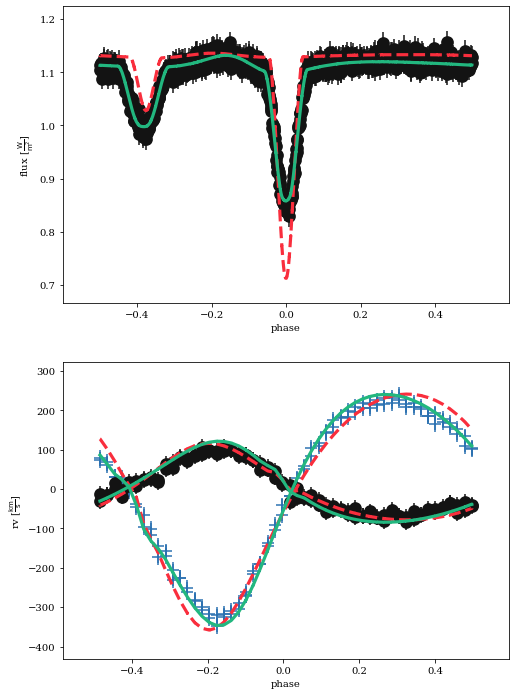

In [38]:
_ = b.plot(x='phases', 
           c={'after_estimators': 'red', 'after_nm': 'green', 'dataset': 'black'}, 
           linestyle={'after_estimators': 'dashed', 'after_nm': 'solid'},
           marker={'dataset': '.'},
           save='figure_optimizer_nm.eps', show=True)

# Determine uncertainties with emcee

So that we don't ignore any degeneracies between parameters and the luminosities, we'll turn off the dataset-scaling we used for optimizing and make sure we have a reasonable value of `pblum@primary` set to roughly obtain the out-of-eclipse flux levels of the observations.

In [40]:
b.set_value_all('pblum_mode', 'component-coupled')

In [41]:
print(b.compute_pblums(compute='fastcompute', dataset='lc01', pbflux=True))

{'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 1.31317671 W>, 'pbflux@lc01': <Quantity 1.10449928 W / m2>}


We'll now create our initializing distribution, including gaussian "balls" around all of the optimized values and a generous boxcar on `pblum@primary`.

In [42]:
# TODO: remove @primary@lc01 once bug fixed
b.add_distribution({'teffratio': phoebe.gaussian_around(0.1),
                    'requivsumfrac': phoebe.gaussian_around(0.1),
                    'incl@binary': phoebe.gaussian_around(3),
                    'q': phoebe.gaussian_around(0.1),
                    'ecc': phoebe.gaussian_around(0.05),
                    'per0': phoebe.gaussian_around(5),
                    'pblum@primary@lc01': phoebe.uniform_around(2)},
                    distribution='ball_around_optimized_solution')

<ParameterSet: 7 parameters | components: primary, binary>

We can look at this combined set of distributions, which will be used to sample the initial values of our walkers in [emcee](../api/phoebe.parameters.solver.sampler.emcee.md).

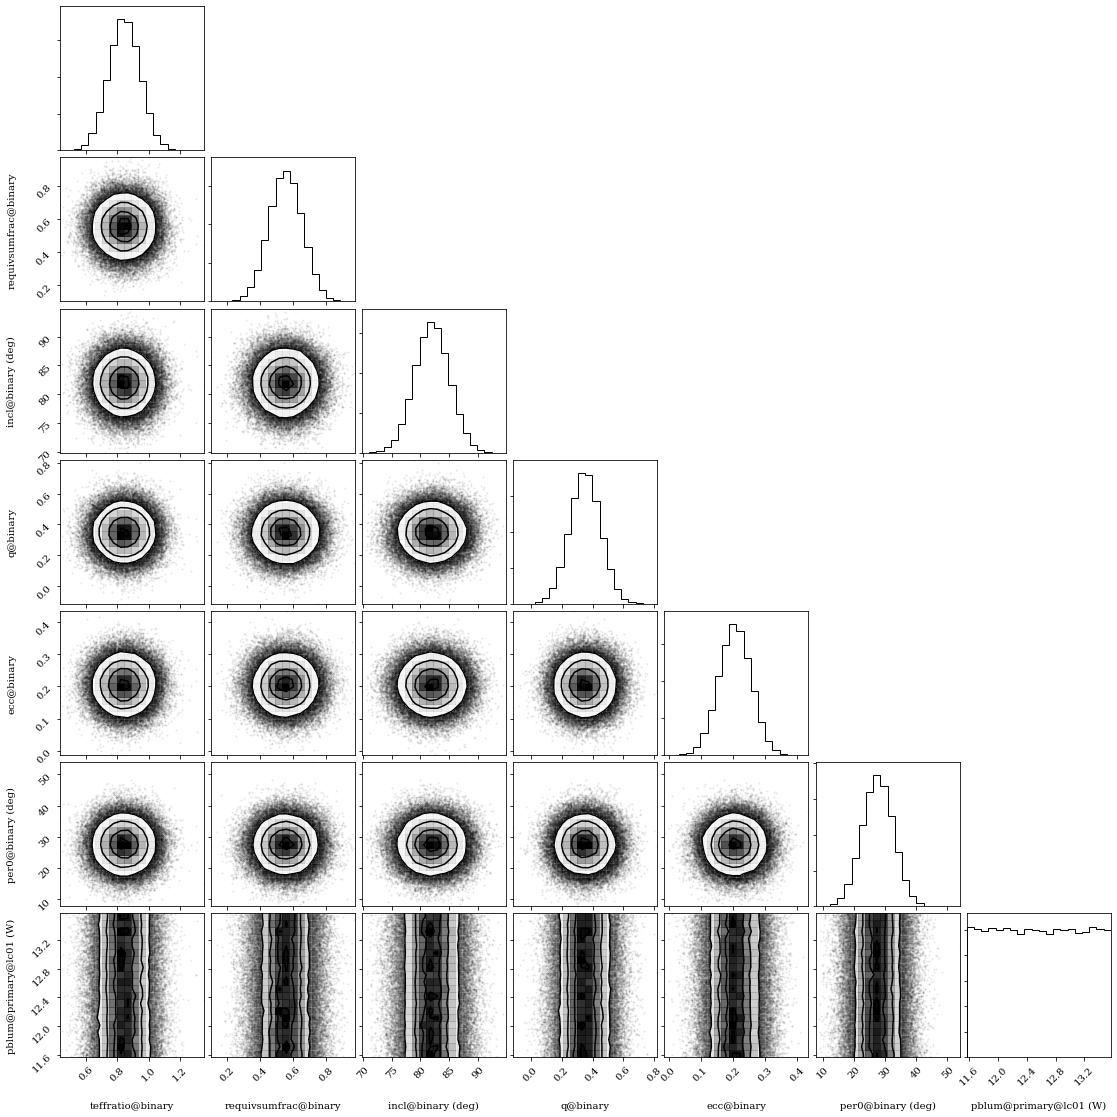

In [43]:
_ = b.plot_distribution_collection('ball_around_optimized_solution', show=True)

In [44]:
b.add_solver('sampler.emcee',
             init_from='ball_around_optimized_solution',
             compute='fastcompute',
             solver='emcee_solver')

<ParameterSet: 13 parameters | qualifiers: comments, expose_failed, priors, niters, progress_every_niters, init_from, burnin_factor, compute, priors_combine, thin_factor, nwalkers, init_from_combine, continue_from>

Since we'll need a lot of iterations, we'll export the solver to an HPC cluster (with [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md)) and import the solution (with [b.import_solution](../api/phoebe.frontend.bundle.Bundle.import_solution.md)).  We'll [save](../api/phoebe.parameters.ParameterSet.save.md) the bundle first so that we can interrupt the notebook and return to the following line, if needed.

In [45]:
b.save('figure_examples_before_emcee.bundle')
b.export_solver('figure_examples_run_emcee.py', 
                solver='emcee_solver',
                niters=2000, progress_every_niters=250, 
                nwalkers=16,
                solution='emcee_sol',
                pause=True)

* optional:  call b.save(...) to save the bundle to disk, you can then safely close the active python session and recover the bundle with phoebe.load(...)
* run figure_examples_run_emcee.py (within mpirun or on an external machine, if desired)
* once completed, copy figure_examples_run_emcee.py.out to this directory, if necessary
* press enter to exit this pause
* call b.import_solution('figure_examples_run_emcee.py.out')

(press enter to continue)


('figure_examples_run_emcee.py', 'figure_examples_run_emcee.py.out')

In [2]:
b = phoebe.load('figure_examples_before_emcee.bundle')
b.import_solution('figure_examples_run_emcee.py.out.progress', solution='emcee_sol')

<ParameterSet: 18 parameters | qualifiers: adopt_parameters, fitted_twigs, samples, failed_samples, thin, progress, imported_job, lnprob_cutoff, burnin, adopt_distributions, fitted_units, distributions_convert, autocorr_time, wrap_central_values, fitted_uniqueids, lnprobabilities, adopt_values, acceptance_fractions>

Alternatively, we could run the solver locally as we've seen before, but probably would want to run less iterations:

```
b.run_solver('emcee_solver', niters=300, nwalkers=16, solution='emcee_sol')
```

in which case calling `b.import_solution` is not necessary.

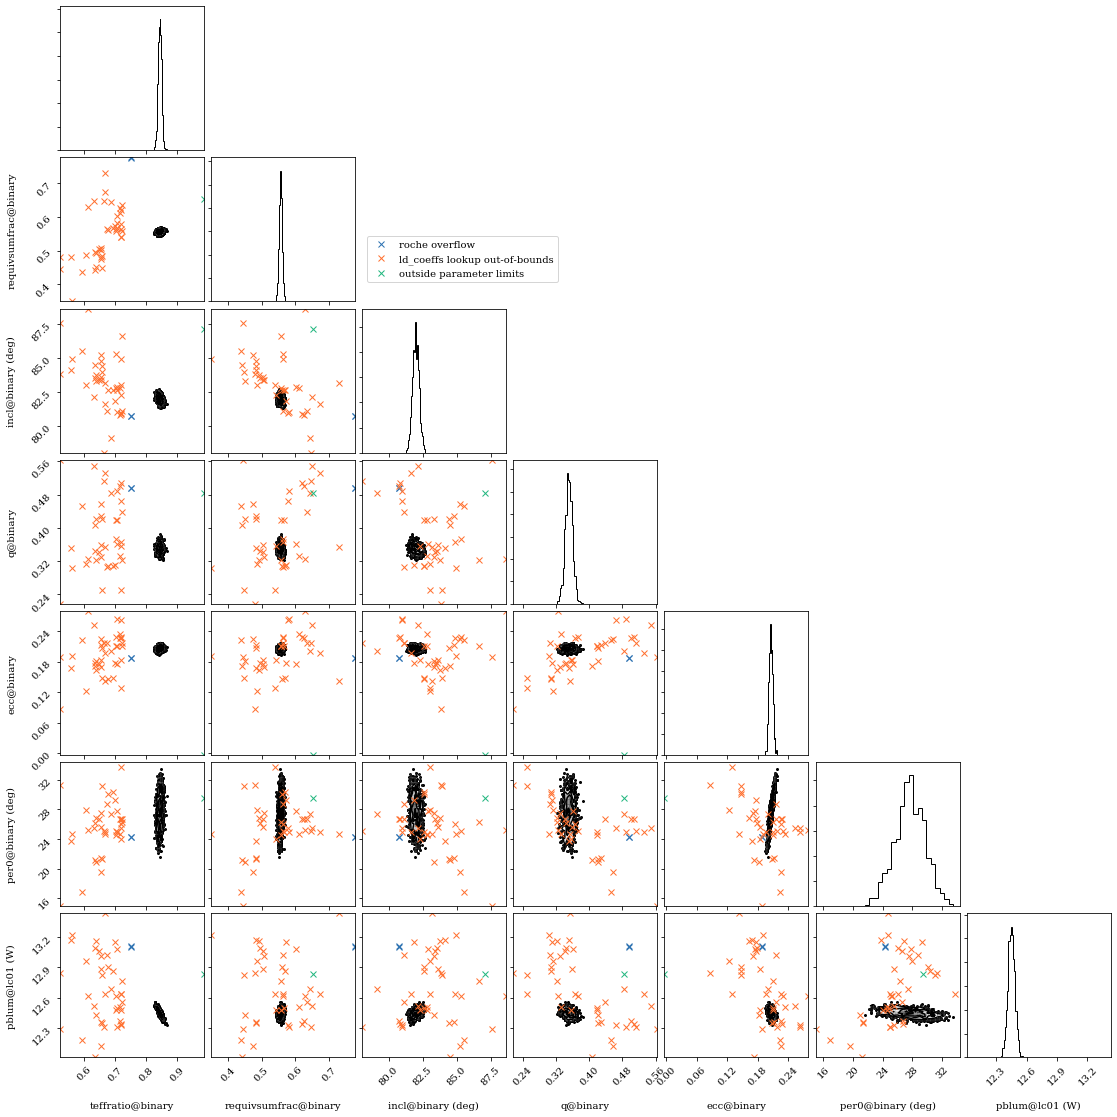

In [3]:
_ = b.plot('emcee_sol', style='failed', 
           save='figure_emcee_failed_samples.eps', show=True)

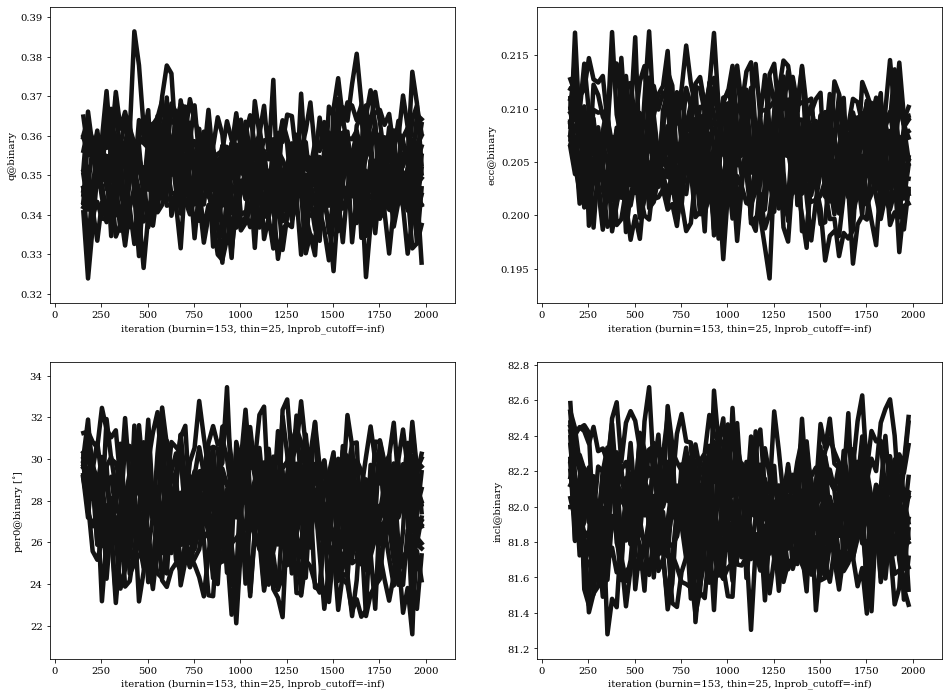

In [62]:
_ = b.plot('emcee_sol', style='walks', c='black', 
           adopt_parameters=['q', 'ecc', 'per0', 'incl@binary'],
           save='figure_emcee_walks.eps', show=True)

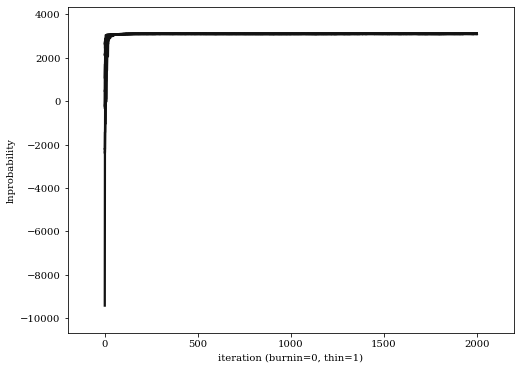

In [63]:
_ = b.plot('emcee_sol', style='lnprobabilities', c='black',
           burnin=0, thin=1,
           save='figure_emcee_lnprobabilities_all.eps', show=True)

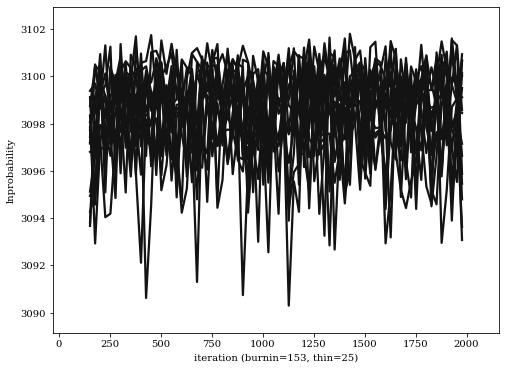

In [64]:
_ = b.plot('emcee_sol', style='lnprobabilities', c='black',
           save='figure_emcee_lnprobabilities.eps', show=True)

# Accessing posteriors from emcee run

**TODO**: explain the difference between `parameters` and `adopt_parameters`, or consider merging in the code so this isn't possible (or rename to be more self-explanatory).

In [65]:
#_ = b.plot('emcee_sol', style='corner', show=True)

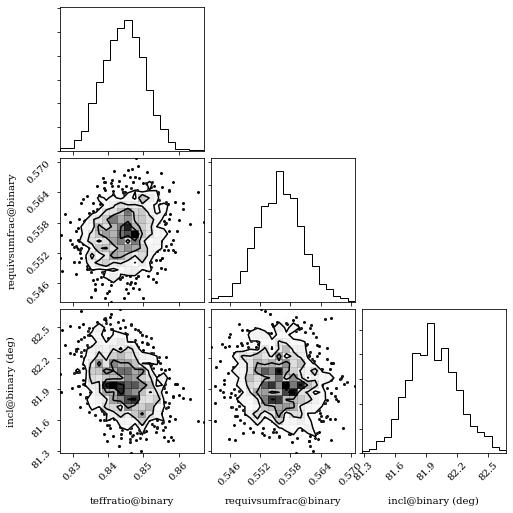

In [66]:
_ = b.plot('emcee_sol', style='corner', parameters=['teffratio', 'requivsumfrac', 'incl@binary'], 
           save='figure_posteriors_mvsamples.eps', show=True)

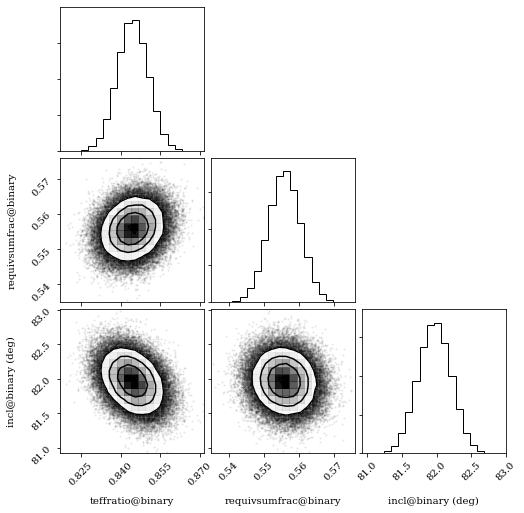

In [67]:
_ = b.plot('emcee_sol', style='corner', parameters=['teffratio', 'requivsumfrac', 'incl@binary'], 
           distributions_convert='mvgaussian',
           save='figure_posteriors_mvgaussian.eps', show=True)

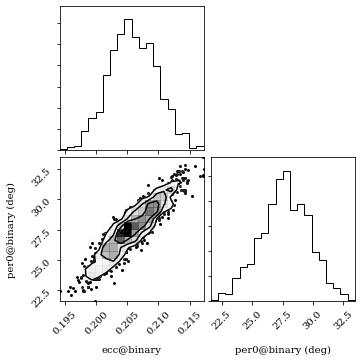

In [68]:
_ = b.plot('emcee_sol', style='corner', parameters=['ecc', 'per0'], 
           save='figure_posteriors_ew.eps', show=True)

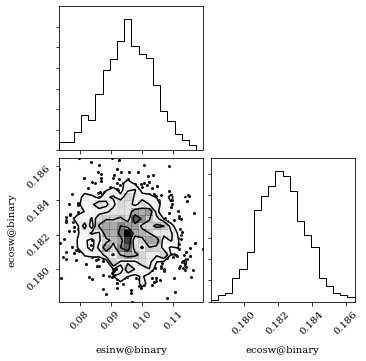

In [69]:
_ = b.plot('emcee_sol', style='corner', parameters=['esinw', 'ecosw'], 
           save='figure_posteriors_ecs.eps', show=True)

In [5]:
b.run_compute(compute='fastcompute', 
              sample_from='emcee_sol', sample_num=100, sample_mode='3-sigma',
              model='emcee_posts')

<ParameterSet: 12 parameters | kinds: rv, lc>

In [7]:
b.save('figure_examples_after_sample_from.bundle')

'figure_examples_after_sample_from.bundle'

In [1]:
#### REMOVE THIS CELL ONCE DONE TESTING - THIS JUST ALLOWS TO START THE SCRIPT HERE


import matplotlib.pyplot as plt

plt.rc('font', family='serif')

import phoebe
import numpy as np

logger = phoebe.logger('error')

# we'll set the random seed so that the noise model is reproducible
np.random.seed(123456789)

In [2]:
b = phoebe.load('figure_examples_after_sample_from.bundle')

*** plot_kwargss [{'x': <Quantity [-0.09910524, -0.08914508, -0.07918492, ..., -0.11902556,
           -0.1090654 , -0.09910524]>, 'y': <Quantity [1.13839808, 1.13347281, 1.12665755, ..., 1.11805765, 1.12361047,
           1.10986323] W / m2>, 'c': '#131313', 's': 0.005, 'marker': '.', 'autofig_method': 'plot', 'xlabel': 'phase', 'xqualifier': 'phases', 'linebreak': 'x-', 'yerror': <Quantity [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02] W / m2>, 'ylabel': 'flux', 'yqualifier': 'fluxes', 'z': 0, 'i': 'x', 'iqualifier': None, 'linestyle': 'none', 'label': 'lc01'}, {'x': <Quantity [-0.09910524, -0.08914508, -0.07918492, ..., -0.11902556,
           -0.1090654 , -0.09910524]>, 'y': <Quantity [[1.10858963, 1.11041748, 1.11248461],
           [1.10388904, 1.1061726 , 1.10831366],
           [1.09949602, 1.10223559, 1.10450084],
           ...,
           [1.11675376, 1.11893807, 1.12126053],
           [1.11278419, 1.11478208, 1.11686198],
           [1.10858963, 1.11041748, 1.11248461]] W / m2>

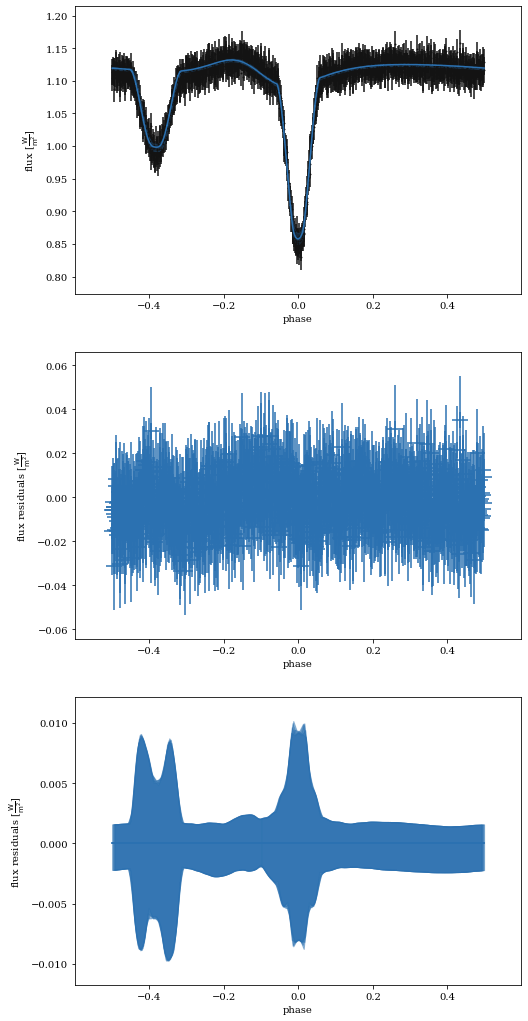

In [10]:
# TODO: fix this so that passing model to plot doesn't exclude the observations
_ = b.plot(kind='lc', model='emcee_posts', x='phases', y='fluxes', 
           c={'dataset': 'black', 'model': 'blue'},
           s={'dataset': 0.005},
           marker={'dataset': '.'})
_ = b.plot(kind='lc', model='emcee_posts', x='phases', y='residuals', 
           c={'dataset': 'black', 'model': 'blue'},
           save='figure_posteriors_sample_from_lc.eps', show=True)

*** plot_kwargss [{'x': <Quantity [-0.09910524, -0.00295139,  0.09320245,  0.1893563 ,  0.28551015,
            0.38166399,  0.47781784, -0.42602832, -0.32987447, -0.23372062,
           -0.13756678, -0.04141293,  0.05474091,  0.15089476,  0.24704861,
            0.34320245,  0.4393563 , -0.46448985, -0.36833601, -0.27218216,
           -0.17602832, -0.07987447,  0.01627938,  0.11243322,  0.20858707,
            0.30474091,  0.40089476,  0.49704861, -0.40679755, -0.3106437 ,
           -0.21448985, -0.11833601, -0.02218216,  0.07397168,  0.17012553,
            0.26627938,  0.36243322,  0.45858707, -0.44525909, -0.34910524,
           -0.25295139, -0.15679755, -0.0606437 ,  0.03551015,  0.13166399,
            0.22781784,  0.32397168,  0.42012553, -0.48372062, -0.38756678,
           -0.29141293, -0.19525909, -0.09910524, -0.00295139,  0.09320245,
            0.1893563 ,  0.28551015,  0.38166399,  0.47781784, -0.42602832,
           -0.32987447, -0.23372062, -0.13756678, -0.04141293,  

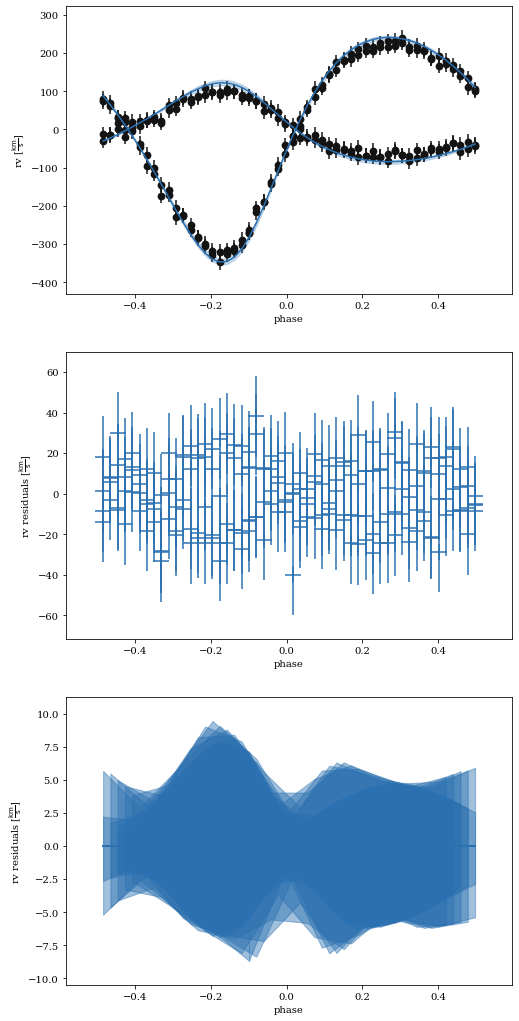

In [11]:
# TODO: fix this so model and dataset are in same panel for residuals 
# and so observations are included in top-panel (problem seems to be units on phase)
_ = b.plot(kind='rv', model='emcee_posts', x='phases', y='rvs',
          c={'dataset': 'black', 'model': 'blue'},
          marker={'dataset': '.'})
_ = b.plot(kind='rv', model='emcee_posts', x='phases', y='residuals', 
           c={'dataset': 'black', 'model': 'blue'},
           save='figure_posteriors_sample_from_rv.eps', show=True)

# Sampling with dynesty

The posterior plots in the paper were all created from the `emcee` results, but we'll also run the `dynesty` sampler on the same system.

`dynesty` samples directly from the priors, so we shouldn't use the same gaussian balls we did for `emcee`.  Instead, we'll create a narrow box around the solution with widths somewhat estimated from the `emcee` cornerplot.  We can do this to save time for this example because we know the solution, but in practice these would likely need to be much more conservatively set.

In [3]:
b.add_distribution({'teffratio': phoebe.uniform_around(0.1),
                    'requivsumfrac': phoebe.uniform_around(0.1),
                    'incl@binary': phoebe.uniform_around(0.5),
                    'q': phoebe.uniform_around(0.1),
                    'ecc': phoebe.uniform_around(0.05),
                    'per0': phoebe.uniform_around(6),
                    'pblum@primary@lc01': phoebe.uniform_around(0.5)},
                    distribution='dynesty_uninformative_priors')

<ParameterSet: 7 parameters | components: binary, primary>

In [4]:
b.add_solver('sampler.dynesty',
             compute='fastcompute',
             priors='dynesty_uninformative_priors',
             solver='dynesty_solver'
            )

<ParameterSet: 8 parameters | qualifiers: maxiter, nlive, priors_combine, compute, comments, maxcall, progress_every_niters, priors>

In [5]:
b.save('figure_examples_before_dynesty.bundle')
b.export_solver('figure_examples_run_dynesty.py', 
                solver='dynesty_solver',
                maxiter=10000, maxcall=int(1e6), progress_every_niters=100, 
                solution='dynesty_sol',
                pause=True)

* optional:  call b.save(...) to save the bundle to disk, you can then safely close the active python session and recover the bundle with phoebe.load(...)
* run figure_examples_run_dynesty.py (within mpirun or on an external machine, if desired)
* once completed, copy figure_examples_run_dynesty.py.out to this directory, if necessary
* press enter to exit this pause
* call b.import_solution('figure_examples_run_dynesty.py.out')

(press enter to continue)


('figure_examples_run_dynesty.py', 'figure_examples_run_dynesty.py.out')

In [ ]:
#### REMOVE THIS CELL ONCE DONE TESTING - THIS JUST ALLOWS TO START THE SCRIPT HERE


import matplotlib.pyplot as plt

plt.rc('font', family='serif')

import phoebe
import numpy as np

logger = phoebe.logger('error')

# we'll set the random seed so that the noise model is reproducible
np.random.seed(123456789)

In [6]:
b = phoebe.load('figure_examples_before_dynesty.bundle')
b.import_solution('figure_examples_run_dynesty.py.out', solution='dynesty_sol')

<ParameterSet: 28 parameters | qualifiers: logzerr, imported_job, logvol, eff, scale, samples_bound, adopt_values, bound_iter, logl, ncall, nlive, wrap_central_values, logwt, distributions_convert, fitted_uniqueids, adopt_parameters, niter, samples_it, information, logz, comments, samples_u, adopt_distributions, samples, fitted_twigs, fitted_units, samples_id, progress>

*** plot_kwargss ({'style': 'trace', 'savefig': 'figure_dynesty_trace.eps', 'results': {'wrap_central_values': {'RtGkeOwMJKWcqQVHFoQrexFeBfWwzg': 27.52861902994414, 'uPNslxMIUWylztOXKTPODSDjQvOmGn': 82.00816577613946}, 'fitted_uniqueids': array(['StQEXsqYJqqoArjPVARwMVfFLUqzeu', 'ehiqQfiRyGUCwfjkiRUTNCpVueiHiE',
       'uPNslxMIUWylztOXKTPODSDjQvOmGn', 'IdgLAbomTXGqsMuGoBiRkthzpfkyVT',
       'rtoXbSOGuKvzTybUvOPSPfrTijgWPa', 'RtGkeOwMJKWcqQVHFoQrexFeBfWwzg',
       'HBAlPbPnAqFHoeDsdPilmCifYxrIHj'], dtype='<U30'), 'fitted_twigs': array(['teffratio@binary@component', 'requivsumfrac@binary@component',
       'incl@binary@orbit@component', 'q@binary@orbit@component',
       'ecc@binary@orbit@component', 'per0@binary@orbit@component',
       'pblum@primary@lc01@lc@dataset'], dtype='<U30'), 'fitted_units': array(['', '', 'deg', '', '', 'deg', 'W'], dtype='<U3'), 'adopt_parameters': ['teffratio@binary@component', 'requivsumfrac@binary@component', 'incl@binary@orbit@component', 'q@binary@orb

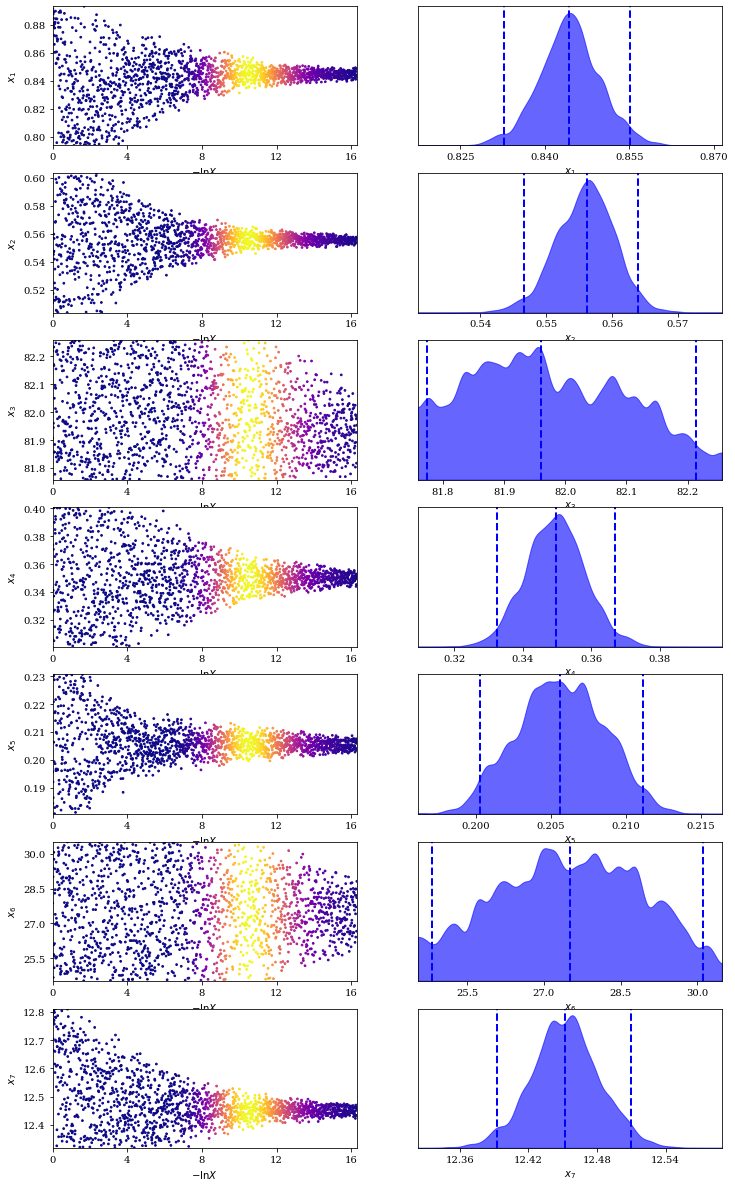

In [10]:
afig, mplfig = _ = b.plot('dynesty_sol', style='trace', 
           savefig='figure_dynesty_trace.eps', show=True)

In [12]:
mplfig.tight_layout()
mplfig.savefig('figure_dynesty_trace.eps')

*** plot_kwargss ({'style': 'run', 'results': {'wrap_central_values': {'RtGkeOwMJKWcqQVHFoQrexFeBfWwzg': 27.52861902994414, 'uPNslxMIUWylztOXKTPODSDjQvOmGn': 82.00816577613946}, 'fitted_uniqueids': array(['StQEXsqYJqqoArjPVARwMVfFLUqzeu', 'ehiqQfiRyGUCwfjkiRUTNCpVueiHiE',
       'uPNslxMIUWylztOXKTPODSDjQvOmGn', 'IdgLAbomTXGqsMuGoBiRkthzpfkyVT',
       'rtoXbSOGuKvzTybUvOPSPfrTijgWPa', 'RtGkeOwMJKWcqQVHFoQrexFeBfWwzg',
       'HBAlPbPnAqFHoeDsdPilmCifYxrIHj'], dtype='<U30'), 'fitted_twigs': array(['teffratio@binary@component', 'requivsumfrac@binary@component',
       'incl@binary@orbit@component', 'q@binary@orbit@component',
       'ecc@binary@orbit@component', 'per0@binary@orbit@component',
       'pblum@primary@lc01@lc@dataset'], dtype='<U30'), 'fitted_units': array(['', '', 'deg', '', '', 'deg', 'W'], dtype='<U3'), 'adopt_parameters': ['teffratio@binary@component', 'requivsumfrac@binary@component', 'incl@binary@orbit@component', 'q@binary@orbit@component', 'ecc@binary@orbit@componen

/home/kyle/.local/lib/python3.7/site-packages/dynesty/plotting.py:173: UserWarning: The number of iterations and samples differ by an amount that isn't the number of final live points. `mark_final_live` has been disabled.
  warnings.warn("The number of iterations and samples differ "
/home/kyle/.local/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/kyle/.local/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


ValueError: Axis limits cannot be NaN or Inf

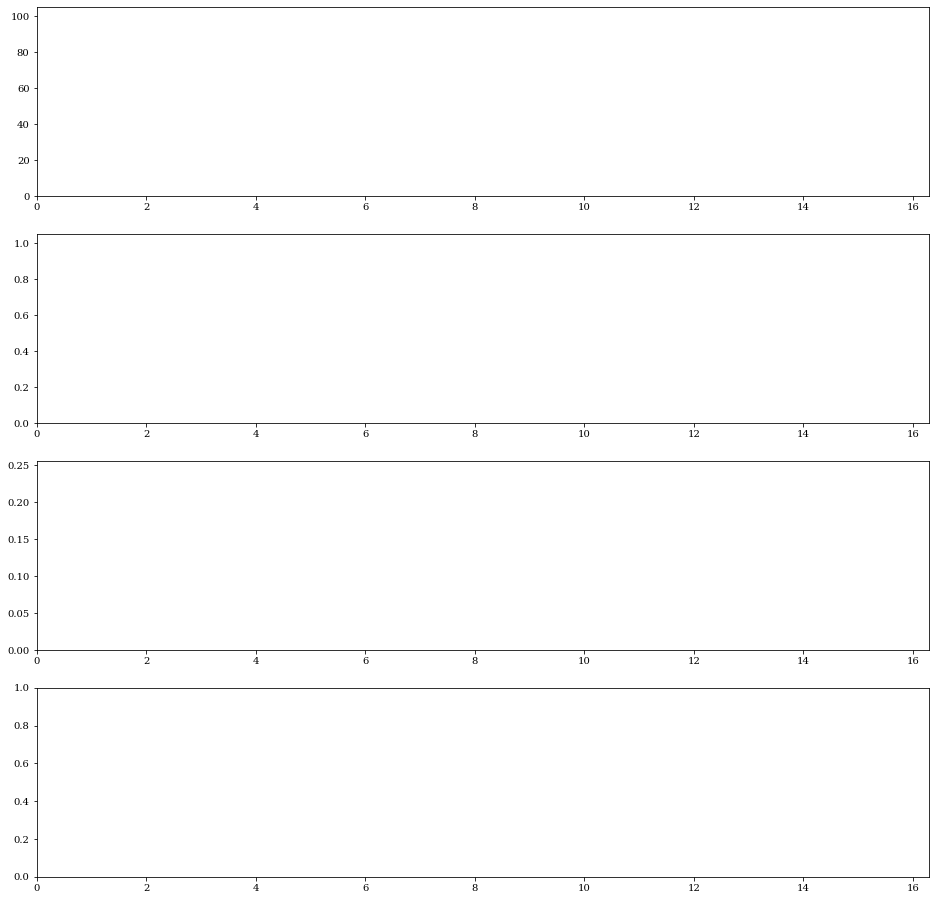

In [8]:
_ = b.plot('dynesty_sol', style='run', 
           show=True)

*** plot_kwargss ({'style': 'corner', 'results': {'wrap_central_values': {'RtGkeOwMJKWcqQVHFoQrexFeBfWwzg': 27.52861902994414, 'uPNslxMIUWylztOXKTPODSDjQvOmGn': 82.00816577613946}, 'fitted_uniqueids': array(['StQEXsqYJqqoArjPVARwMVfFLUqzeu', 'ehiqQfiRyGUCwfjkiRUTNCpVueiHiE',
       'uPNslxMIUWylztOXKTPODSDjQvOmGn', 'IdgLAbomTXGqsMuGoBiRkthzpfkyVT',
       'rtoXbSOGuKvzTybUvOPSPfrTijgWPa', 'RtGkeOwMJKWcqQVHFoQrexFeBfWwzg',
       'HBAlPbPnAqFHoeDsdPilmCifYxrIHj'], dtype='<U30'), 'fitted_twigs': array(['teffratio@binary@component', 'requivsumfrac@binary@component',
       'incl@binary@orbit@component', 'q@binary@orbit@component',
       'ecc@binary@orbit@component', 'per0@binary@orbit@component',
       'pblum@primary@lc01@lc@dataset'], dtype='<U30'), 'fitted_units': array(['', '', 'deg', '', '', 'deg', 'W'], dtype='<U3'), 'adopt_parameters': ['teffratio@binary@component', 'requivsumfrac@binary@component', 'incl@binary@orbit@component', 'q@binary@orbit@component', 'ecc@binary@orbit@compo

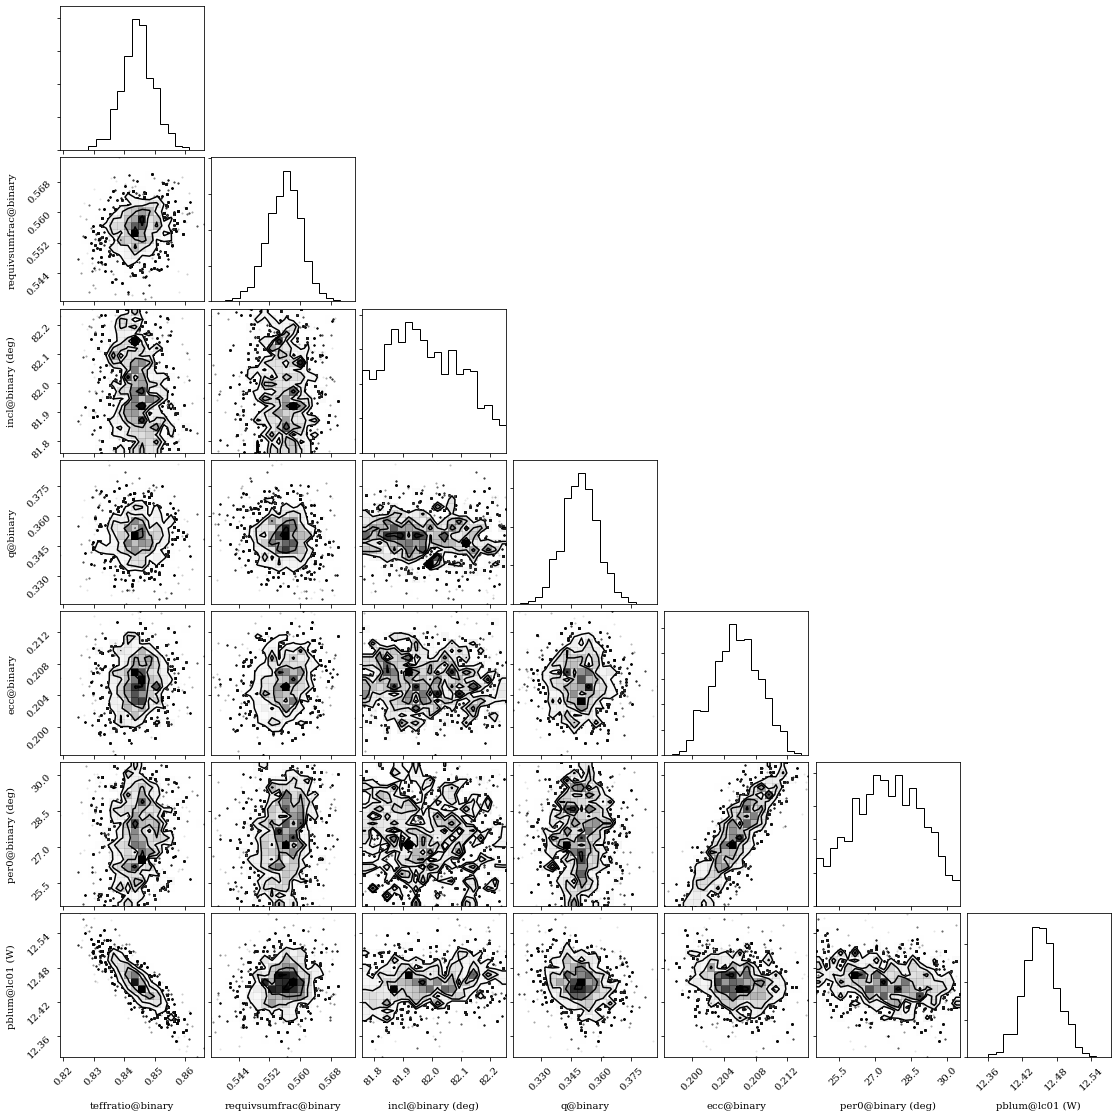

In [9]:
_ = b.plot('dynesty_sol', style='corner', 
           show=True)